Use DuckDuckGo to search for images of "bird photos". The majority of the code is from: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [1]:
!pip install -Uqq duckduckgo-search fastai fastdownload

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.6.2 requires requests<2.29,>=2.24.0, but you have requests 2.31.0 which is incompatible.
librosa 0.10.0 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
#yunny's way
"""
from duckduckgo_search import ddg_images
from fastai.vision.all import *
from fastdownload import download_url


def searchImages(keyName, maxResults):
    print(f"'{keyName}' searching")
    results = ddg_images(keyName, max_results = maxResults)
    return results

"""
"""
With my approach, this is not ideal because.. 
(1) when I have multiple search terms, I need to have a simliar getUrlsFromImages for each serach term. 
(2) Also, for each result of the image, I am checking 'image' object. 
(3) Download_url path is directing to the image. 

Both (1) & (2) & (3) can be handled.. with download_image function. 
"""
"""
def getUrlsFromImages(imageResults):
    print("get urls from image objects")
    urlList = []
    i = 1
    for result in imageResults:
        url = result.get('image')
        dest = Path(f"bird {i}")
        path = download_url(url, dest, show_progress=False)
        print(f"this is path to an image: {path}")
        urlList.append(path)
        i += 1
    return urlList
                    
searchedImages = searchImages("bird",2)
print(len(searchedImages))
urls = getUrlsFromImages(searchedImages)
"""
#download the image
#url = searchImages("bird",1)[0].get('image')
#dest = Path('bird.jpg')
#path = download_url(url, dest, show_progress=False)


# open the image
#Image.open(path).to_thumb(256,512) # I can open it after I dwonload it. Also if I put it in a variable, it does not. #to_thumb is basically PIL's thumbnail but returns a copy. PIL version operates on the image itself. 
# showing an image
#im.show() #showing an image does not work for some reasons.



'\ndef getUrlsFromImages(imageResults):\n    print("get urls from image objects")\n    urlList = []\n    i = 1\n    for result in imageResults:\n        url = result.get(\'image\')\n        dest = Path(f"bird {i}")\n        path = download_url(url, dest, show_progress=False)\n        print(f"this is path to an image: {path}")\n        urlList.append(path)\n        i += 1\n    return urlList\n                    \nsearchedImages = searchImages("bird",2)\nprint(len(searchedImages))\nurls = getUrlsFromImages(searchedImages)\n'

In [3]:
#Jeremy's way.
from duckduckgo_search import ddg_images
from fastai.vision.all import *
#from fastdownload import download_url

path = Path('rabbit_or_corgi')
def searchImages(keyName, maxResults):
    print(f"'{keyName}' searching")
    results = L(ddg_images(keyName, max_results = maxResults)).itemgot('image') #oh this is powerful as in I can use the key in the dictinary as index. 
    return results

keyNames = "rabbit", "corgi"
# folder name can be: rabbit, corgi, and the search can be white.
for keyName in keyNames:
    dest = (path/keyName)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=searchImages(f"white {keyName}", 3)) #destination is going to be a folder
    download_images(dest, urls=searchImages(f"red {keyName}", 3)) #destination is going to be a folder
    resize_images(dest, max_size=400, dest=dest) #all the pictures in path, resize them and put them back. 
    
"""
download_images: benefits are I can pass the list of urls and it is handling downloading each image there. 
resize_images: benefits are I can specify the path where my images are, and destination where I want to have resize. It handles the logic in-between. 
"""

'white rabbit' searching


/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.7/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'red rabbit' searching
'white corgi' searching
'red corgi' searching


'\ndownload_images: benefits are I can pass the list of urls and it is handling downloading each image there. \nresize_images: benefits are I can specify the path where my images are, and destination where I want to have resize. It handles the logic in-between. \n'

In [4]:
# remove failed ones. 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

rabbit_or_corgi


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.526947,3.662566,0.500000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,1.346634,2.718828,0.500000,00:01
1,1.159599,1.926470,0.500000,00:01
2,0.902806,0.920141,0.500000,00:01
3,0.679022,0.479013,0.250000,00:01
4,0.573182,0.252873,0.250000,00:01
5,0.511175,0.094493,0.000000,00:01


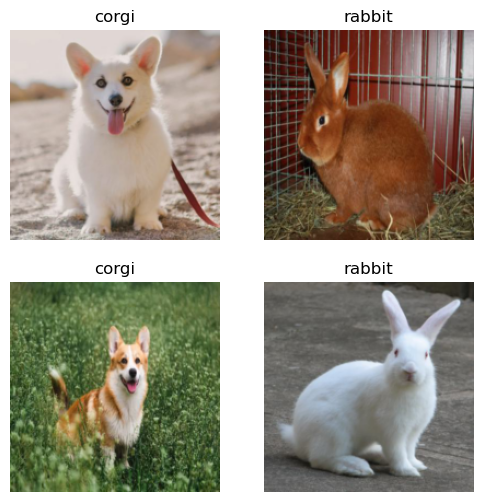

In [5]:
# create a datablock and dataloader
print(path)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42), #technically, smaller training set. Will it impact the result?
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path,bs=4)

dls.show_batch(max_n=8)
# create a learner and fine tune the data with my input data. make the learner predict the data. 
learner = vision_learner(dls,resnet18, metrics=error_rate)
learner.fine_tune(6)

In [6]:
# get the test data
urls = searchImages('white rabbit', 1)
from fastdownload import download_url
dest = 'rabbit.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open('rabbit.jpg').to_thumb(256,256)
# make the learner predict the data. 

strReturn, intReturn, probs = learner.predict('rabbit.jpg') # is probs alphabetically order?
print(f"what is this image?: {strReturn}")
print(f"what is the probability of the image to be rabbit?: {probs[0]}, {probs[1]}")

'white rabbit' searching


what is this image?: rabbit
what is the probability of the image to be rabbit?: 0.22493049502372742, 0.7750694751739502


My attempt to apply the same method for cheesecake is availble [here](https://www.kaggle.com/bigyunicorn/image-classifier-which-cheesecake-it-this)